In [18]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB3, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os, datetime

In [19]:
IMG_SIZE        = 300
BATCH_SIZE      = 32
EPOCHS_HEAD     = 10          # 先训练分类头
EPOCHS_FINE     = 20          # 再微调
TOP_N_TRAINABLE = 20          # 解冻的最顶层数
NUM_CLASSES     = 5
DATA_DIR        = 'mix_dataset'
MODEL_PATH      = 'mix_dataset_model.h5'

In [20]:
def build_datasets():
    aug = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomContrast(0.1),
    ])

    def _process(x, y, training=False):
        x = tf.cast(x, tf.float32)
        x = preprocess_input(x)               # ★ 统一预处理 (-1~1)
        if training:
            x = aug(x)
        return x, y

    raw_train = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(DATA_DIR, 'train'),
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        label_mode='int',
        shuffle=True
    )
    raw_val = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(DATA_DIR, 'validation'),
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        label_mode='int',
        shuffle=False
    )

    class_names = raw_train.class_names
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = raw_train.map(lambda x, y: _process(x, y, training=True)).prefetch(AUTOTUNE)
    val_ds   = raw_val. map(lambda x, y: _process(x, y, training=False)).prefetch(AUTOTUNE)
    return train_ds, val_ds, class_names

In [21]:
def build_model():
    base = EfficientNetB3(include_top=False, weights='imagenet',
                          input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base.trainable = False
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.5)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(base.input, outputs)
    return model, base


In [ ]:
def train():
    train_ds, val_ds, class_names = build_datasets()
    print("类别顺序:", class_names)

    model, base = build_model()

    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
        ReduceLROnPlateau(patience=3, factor=0.3, verbose=1, monitor='val_loss')
    ]

    # Phase 1：只训练分类头
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    history1 = model.fit(train_ds, epochs=EPOCHS_HEAD,
                         validation_data=val_ds, callbacks=callbacks)

    # Phase 2：解冻部分卷积层微调
    base.trainable = True
    for layer in base.layers[:-TOP_N_TRAINABLE]:
        layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    history2 = model.fit(train_ds,
                         epochs=EPOCHS_HEAD + EPOCHS_FINE,
                         initial_epoch=EPOCHS_HEAD,
                         validation_data=val_ds,
                         callbacks=callbacks)

    # 保存模型
    model.save(MODEL_PATH)
    print(f"✅ 模型已保存：{MODEL_PATH}")

    # 画图
    for k in history1.history:
        history1.history[k].extend(history2.history[k])
    plot_history(history1.history)


In [23]:
def plot_history(hist):
    acc, val_acc = hist['accuracy'], hist['val_accuracy']
    loss, val_loss = hist['loss'], hist['val_loss']
    epochs = range(len(acc))
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.plot(epochs, acc,label='train'); plt.plot(epochs, val_acc,label='val')
    plt.title('Accuracy'); plt.legend()
    plt.subplot(1,2,2); plt.plot(epochs, loss,label='train'); plt.plot(epochs, val_loss,label='val')
    plt.title('Loss'); plt.legend()
    plt.tight_layout(); plt.show()

Found 7631 files belonging to 5 classes.
Found 1291 files belonging to 5 classes.
类别顺序: ['Pallas cats', 'Persian cats', 'Ragdolls', 'Singapura cats', 'Sphynx cats']
Epoch 1/10


2025-07-04 13:13:20.091041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-07-04 13:13:20.158290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-07-04 13:13:25.623789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - ETA: 0s - loss: 0.4115 - accuracy: 0.8614

2025-07-04 13:14:26.790824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 77s 292ms/step - loss: 0.4115 - accuracy: 0.8614 - val_loss: 0.1755 - val_accuracy: 0.9473 - lr: 0.0010
Epoch 2/10


2025-07-04 13:14:36.960019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 67s 281ms/step - loss: 0.2069 - accuracy: 0.9283 - val_loss: 0.1504 - val_accuracy: 0.9512 - lr: 0.0010
Epoch 3/10


2025-07-04 13:15:44.378511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 68s 285ms/step - loss: 0.1847 - accuracy: 0.9324 - val_loss: 0.1452 - val_accuracy: 0.9512 - lr: 0.0010
Epoch 4/10


2025-07-04 13:16:52.789619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 68s 282ms/step - loss: 0.1764 - accuracy: 0.9340 - val_loss: 0.1340 - val_accuracy: 0.9582 - lr: 0.0010
Epoch 5/10


2025-07-04 13:18:00.602909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 68s 284ms/step - loss: 0.1645 - accuracy: 0.9400 - val_loss: 0.1330 - val_accuracy: 0.9558 - lr: 0.0010
Epoch 6/10


2025-07-04 13:19:08.773428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 68s 286ms/step - loss: 0.1605 - accuracy: 0.9421 - val_loss: 0.1261 - val_accuracy: 0.9605 - lr: 0.0010
Epoch 7/10


2025-07-04 13:20:17.295000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 67s 279ms/step - loss: 0.1477 - accuracy: 0.9490 - val_loss: 0.1280 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 8/10


2025-07-04 13:21:24.352150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 67s 280ms/step - loss: 0.1518 - accuracy: 0.9480 - val_loss: 0.1263 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 9/10


2025-07-04 13:22:31.639714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 68s 283ms/step - loss: 0.1437 - accuracy: 0.9485 - val_loss: 0.1254 - val_accuracy: 0.9605 - lr: 0.0010
Epoch 10/10


2025-07-04 13:23:39.489667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 71s 298ms/step - loss: 0.1429 - accuracy: 0.9488 - val_loss: 0.1245 - val_accuracy: 0.9613 - lr: 0.0010


Epoch 11/30


2025-07-04 13:24:50.976689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-07-04 13:24:51.043044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-07-04 13:24:54.699640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - ETA: 0s - loss: 0.1736 - accuracy: 0.9391

2025-07-04 13:26:02.028394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 81s 316ms/step - loss: 0.1736 - accuracy: 0.9391 - val_loss: 0.1199 - val_accuracy: 0.9659 - lr: 1.0000e-05
Epoch 12/30


2025-07-04 13:26:12.287005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 71s 298ms/step - loss: 0.1513 - accuracy: 0.9463 - val_loss: 0.1173 - val_accuracy: 0.9659 - lr: 1.0000e-05
Epoch 13/30


2025-07-04 13:27:23.813544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 77s 320ms/step - loss: 0.1467 - accuracy: 0.9463 - val_loss: 0.1127 - val_accuracy: 0.9675 - lr: 1.0000e-05
Epoch 14/30


2025-07-04 13:28:40.666538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 75s 313ms/step - loss: 0.1408 - accuracy: 0.9489 - val_loss: 0.1117 - val_accuracy: 0.9667 - lr: 1.0000e-05
Epoch 15/30


2025-07-04 13:29:55.810502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 76s 318ms/step - loss: 0.1284 - accuracy: 0.9533 - val_loss: 0.1107 - val_accuracy: 0.9682 - lr: 1.0000e-05
Epoch 16/30


2025-07-04 13:31:12.225059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 76s 317ms/step - loss: 0.1237 - accuracy: 0.9570 - val_loss: 0.1100 - val_accuracy: 0.9667 - lr: 1.0000e-05
Epoch 17/30


2025-07-04 13:32:28.386954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 75s 312ms/step - loss: 0.1160 - accuracy: 0.9595 - val_loss: 0.1073 - val_accuracy: 0.9706 - lr: 1.0000e-05
Epoch 18/30


2025-07-04 13:33:43.254641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 77s 322ms/step - loss: 0.1114 - accuracy: 0.9604 - val_loss: 0.1057 - val_accuracy: 0.9659 - lr: 1.0000e-05


2025-07-04 13:35:00.470459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 19/30
239/239 [==============================] - 71s 296ms/step - loss: 0.1156 - accuracy: 0.9595 - val_loss: 0.1049 - val_accuracy: 0.9682 - lr: 1.0000e-05
Epoch 20/30


2025-07-04 13:36:16.434349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 73s 305ms/step - loss: 0.1104 - accuracy: 0.9611 - val_loss: 0.1028 - val_accuracy: 0.9682 - lr: 1.0000e-05
Epoch 21/30


2025-07-04 13:37:29.661607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 73s 306ms/step - loss: 0.1079 - accuracy: 0.9627 - val_loss: 0.1027 - val_accuracy: 0.9690 - lr: 1.0000e-05
Epoch 22/30


2025-07-04 13:38:43.191782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 73s 305ms/step - loss: 0.0983 - accuracy: 0.9651 - val_loss: 0.1008 - val_accuracy: 0.9682 - lr: 1.0000e-05
Epoch 23/30


2025-07-04 13:39:56.489012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 74s 309ms/step - loss: 0.0961 - accuracy: 0.9666 - val_loss: 0.1016 - val_accuracy: 0.9682 - lr: 1.0000e-05
Epoch 24/30


2025-07-04 13:41:10.566580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 75s 311ms/step - loss: 0.0953 - accuracy: 0.9682 - val_loss: 0.1010 - val_accuracy: 0.9690 - lr: 1.0000e-05
Epoch 25/30


2025-07-04 13:42:25.130204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 74s 309ms/step - loss: 0.0888 - accuracy: 0.9695 - val_loss: 0.0985 - val_accuracy: 0.9690 - lr: 1.0000e-05
Epoch 26/30


2025-07-04 13:43:39.348759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 77s 323ms/step - loss: 0.0910 - accuracy: 0.9679 - val_loss: 0.0995 - val_accuracy: 0.9675 - lr: 1.0000e-05
Epoch 27/30


2025-07-04 13:44:56.727589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 75s 314ms/step - loss: 0.0810 - accuracy: 0.9722 - val_loss: 0.0992 - val_accuracy: 0.9667 - lr: 1.0000e-05
Epoch 28/30


2025-07-04 13:46:12.180736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - ETA: 0s - loss: 0.0850 - accuracy: 0.9716
Epoch 28: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.
239/239 [==============================] - 79s 328ms/step - loss: 0.0850 - accuracy: 0.9716 - val_loss: 0.0987 - val_accuracy: 0.9675 - lr: 1.0000e-05
Epoch 29/30


2025-07-04 13:47:30.895459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 82s 342ms/step - loss: 0.0792 - accuracy: 0.9747 - val_loss: 0.0981 - val_accuracy: 0.9675 - lr: 3.0000e-06
Epoch 30/30


2025-07-04 13:48:53.016413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


239/239 [==============================] - 79s 331ms/step - loss: 0.0806 - accuracy: 0.9720 - val_loss: 0.0971 - val_accuracy: 0.9690 - lr: 3.0000e-06
✅ 模型已保存：mix_dataset_model.h5


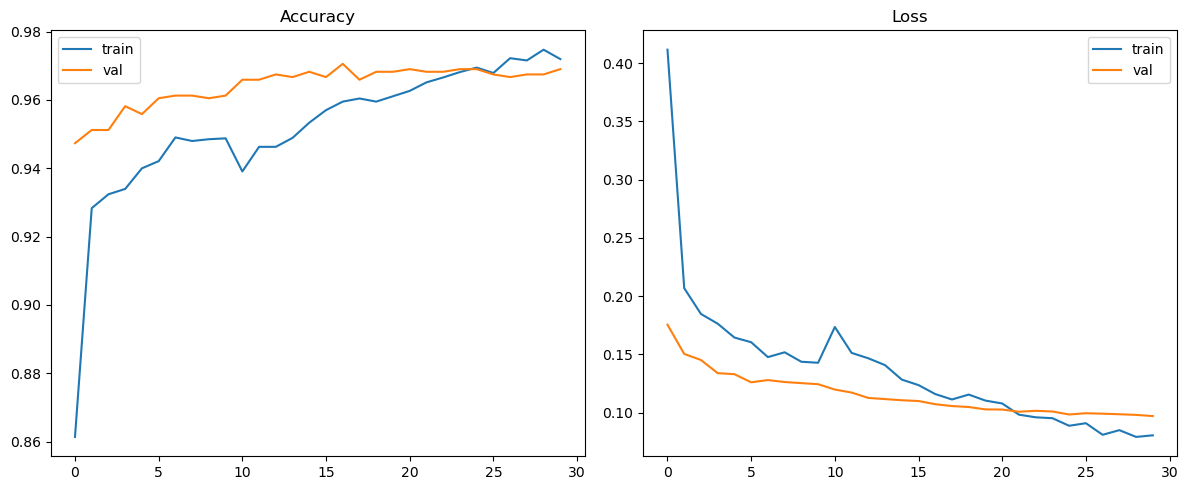

In [24]:
if __name__ == '__main__':
    train()

In [26]:
from tensorflow.keras.models import load_model

def get_model_size(model):
    total_params = model.count_params()
    size_in_bytes = total_params * 4  # float32 = 4 bytes
    size_in_mb = size_in_bytes / (1024 ** 2)
    print(f"模型参数总数: {total_params:,}")
    print(f"估计模型大小: {size_in_mb:.2f} MB")


In [27]:
model = load_model('mix_dataset_model.h5')
model.summary()
get_model_size(model)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 300, 300, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, 300, 300, 3)          7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 300, 300, 3)          0         ['normalization_2[0][0]'